In [1]:

import os
import sys
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
sys.path.append('/burg/palab/users/wm2377/snakemake_versions/scripts/')
import simulations_10042023_classes
from matplotlib import cm
import pickle
from matplotlib.patches import Rectangle, FancyBboxPatch
N2U_flag = 1
sdist = 'expon'
no_new_if_seg = True
simulations_input_file = f"/burg/palab/users/wm2377/snakemake_versions/Figure6and8/sdist_{sdist}/simulations_summary_all.pickle"
theory_results_file = f"/burg/palab/users/wm2377/snakemake_versions/Figure6and8/sdist_{sdist}/analytics_summary_all.pickle"
    
results_dictionary = []
independence = False


In [2]:

# gets data from the file
def load_data(file):

    with open(file,'rb') as fin:
        return pickle.load(fin)

# gets total_var and prop_large from N2U and sigma2 assuming 
# large effect alleles contribute 4 units to variance per mutational input
def transform_variables_from2NU_toTotalVar(N2U,sigma2):

    total_var = sigma2 + N2U*4
    prop_large = 4*N2U/total_var

    return total_var,prop_large

# determine the mean and standard error from a list
# adds a psuedo count of one to lists of all zeros
def get_mean_and_STE_from_list(x):

    mean = np.mean(x)
    standard_error = np.sqrt(np.var(x)/len(x))

    # if mean == 0:
    #     mean = 1/len(x)
    #     standard_error = np.sqrt(mean*(1-mean)/len(x))
        
    return mean,standard_error

# if coloring by prop_large 
def color_by_prop_large(x):

    cmap_norm = mpl.colors.LogNorm(1e-3,1)
    cmap = mpl.colormaps['viridis']
    color = cmap(cmap_norm(x))
    return color

# if coloring by sigma2
def color_by_sigma2(x):

    cmap_norm = mpl.colors.LogNorm(1,100)
    cmap = mpl.colormaps['viridis']
    color = cmap(cmap_norm(x))
    return color

# if coloring by shift
def color_by_shift(x):

    cmap_norm = mpl.colors.LogNorm(1,100)
    cmap = mpl.colormaps['viridis']
    color = cmap(cmap_norm(x))
    return color

def color_by_both(sigma2,shift):
    color='k'
    if np.isclose(sigma2,80,rtol=0.1):
        light = True
    else:
        light = False
    
    if np.isclose(shift,50,rtol=0.1):
        if light:
            color = 'lightcoral'
        else:
            color = 'firebrick'

    elif np.isclose(shift,80,rtol=0.1):
        if light:
            color = 'purple'
        else:
            color = 'cornflowerblue'

    return color


In [3]:

# plot simulation results
def plot_something(results,name,ax):
  for ffff,marker,alpha in zip(['fixations'],['.'],[1,0.3]):
    N2U_sorted_keys = np.sort(list(results.keys())) 
    x_all = {}
    y_all = {}
    y_err_all = {}
    for N2U in N2U_sorted_keys:
        N2U_dict = results[N2U]
        for sigma2,sigma2_dict in N2U_dict.items():
            if sigma2 not in x_all.keys():
                x_all[sigma2] = {}
                y_all[sigma2] = {}
                y_err_all[sigma2] = {}

            for shift,stats_dict_all in sigma2_dict.items():
                if shift not in x_all[sigma2].keys():
                    x_all[sigma2][shift] = []
                    y_all[sigma2][shift] = []
                    y_err_all[sigma2][shift] = []

                try:
                    stats_dict = stats_dict_all[ffff]
                except:
                    stats_dict = stats_dict_all[0][ffff]
                
                #calculate total_var and prop_large
                total_var, prop_large = transform_variables_from2NU_toTotalVar(N2U=N2U,sigma2=sigma2)

                # get_relevant summary stat
                if name == 'prob_new':
                    values = np.array(stats_dict['number'])-np.array(stats_dict['num_segregating'])
                    # values = np.array([i>0 for i in values])
                elif name == 'prob_seg':
                    values = np.array([i for i in stats_dict['num_segregating']])
                elif name == 'prob_multiple':
                    values = np.array([i>1 for i in stats_dict['number']])
                elif 'adaptation' in name:
                    values = np.array([i/shift for i in stats_dict[name]])
                else:
                    values = stats_dict[name]

                mean,standard_error = get_mean_and_STE_from_list(x=values)

                # determine if we are plotting with N2U or total_var as the x-axis
                if N2U_flag == 0:
                    x = total_var
                    color=color_by_prop_large(prop_large)
                else:
                    x = N2U
                    color = color_by_both(sigma2,shift)
                
                # plot the stuff!
                x_all[sigma2][shift].append(x)
                y_all[sigma2][shift].append(mean)
                y_err_all[sigma2][shift].append(2*standard_error)
    
    for sigma2 in x_all.keys():
        for shift in x_all[sigma2].keys():
            if (np.isclose(shift,50,rtol=0.1) and np.isclose(sigma2,40,rtol=0.1)): 
                continue
            else:
                
                ax.errorbar(2*np.array(x_all[sigma2][shift]),y_all[sigma2][shift],y_err_all[sigma2][shift],marker=marker,ls='',color=color_by_both(sigma2,shift),zorder=2,alpha=alpha)


In [ ]:

# determine N2U if only givne total_Var and prop_large
def get_N2U(total_var,prop_large):

    return total_var*prop_large/4

# get expected number of fixations from theory
def theory_number(d,total_var=0,prop_large=0,N2U=[]):

    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)

    #  if we make the assumption that no new alleles fix if a segregating allele fixes
    if no_new_if_seg:
        temp = (d['prob_nsf']**N2U)
    else:
        temp = 1

    prob_no_new = []
    for N2U_temp in N2U:
        new_n_poissons = stats.poisson(d['new_n'][1]*N2U_temp)
        prob_no_new_temp = np.product(new_n_poissons.pmf(0))
        prob_no_new.append(prob_no_new_temp)
    prob_no_new = np.array(prob_no_new)
    # new_n = np.array(new_n)
    # prob_no_new = stats.poisson(new_n).pmf(0)

    # return theory_fixed_any(d=d,N2U=N2U)
    return 1 - ((d['prob_nsf']**N2U)*prob_no_new)
    # return 1 - ((d['prob_nnf']**N2U)*(d['prob_nsf']**N2U))
    # return (d['segregating_n']+d['new_n']*temp)*N2U

def get_factor_for_new(d,N2U):
        #  if we make the assumption that no new alleles fix if a segregating allele fixes
    if no_new_if_seg:
        temp = 1
    else:
        temp = 1
    L = theory_prob_fix_segregating(d=d,N2U=N2U)
    #print(L,np.exp(-d['results']['seg']['fix']*N2U))
    return 1 - L
    # return temp

# get expected adaptation of fixations from theory
def theory_adaptation(d,total_var=0,prop_large=0,N2U=[]):
        #  if we make the assumption that no new alleles fix if a segregating allele fixes
    # temp = get_factor_for_new(d=d,N2U=N2U)

    seg_adaptation = theory_seg_adaptation(d=d,N2U=N2U)
    new_adaptation = theory_new_adaptation(d=d,N2U=N2U)

    return new_adaptation+seg_adaptation

# get expected probability of fixations from theory
def theory_fixed_any(d,total_var=0,prop_large=0,N2U=[]):

    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)

    return theory_prob_fix_segregating(d,N2U=N2U)+theory_prob_fix_new(d,N2U=N2U)

# get expected probability of segregating fixations from theory
def theory_prob_fix_segregating(d,total_var=0,prop_large=0,N2U=[]):

    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)

    if independence == 0:
        return 1 - np.exp(-d['results']['seg']['fix']*N2U)
    else:
        return d['results']['seg']['fix']*N2U

# get expected probability of new fixations from theo
def theory_prob_fix_new(d,total_var=0,prop_large=0,N2U=[]):

    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)
    
    temp = get_factor_for_new(d=d,N2U=N2U)

    if independence == 0:
        return (1 - np.exp(-d['results']['new']['fix']*N2U))*temp
    else:
        return d['results']['new']['fix']*N2U

# calculate the probability that there are multiple fixations
def theory_prob_multiple(d,total_var=0,prop_large=0,N2U=[]):
    
    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)
    return [np.nan]*len(N2U)

# calculate the amount of adaptation from segregating mutations
def theory_seg_adaptation(d,total_var=0,prop_large=0,N2U=[]):
    
    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)
    

    if d['results']['seg']['fix'] > 0:
        seg_adaptation = d['results']['seg']['adaptation']/d['results']['seg']['fix']
    else:
        seg_adaptation = 0
    seg_adaptation = theory_prob_fix_segregating(d,N2U=N2U)*seg_adaptation

    return seg_adaptation

#calculate the amount of adaptation from new mutations
def theory_new_adaptation(d,total_var=0,prop_large=0,N2U=[]):
    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)

    if d['results']['new']['fix'] > 0:
        new_adaptation = d['results']['new']['adaptation']/d['results']['new']['fix']
    else:
        new_adaptation = 0

    new_adaptation = theory_prob_fix_new(d,N2U=N2U)*new_adaptation
    return new_adaptation

# calculate the proportion of adaptation from seg vs new mutations
def theory_proportion_seg_adaptation(d,total_var=0,prop_large=0,N2U=[]):
    if len(N2U) == 0:
        N2U = get_N2U(total_var,prop_large)
    
    seg_adaptation = theory_seg_adaptation(d=d,N2U=N2U)
    new_adaptation = theory_new_adaptation(d=d,N2U=N2U)

    proportion = seg_adaptation/(seg_adaptation+new_adaptation)
    return proportion


# plot theoretical results
def plot_theory_something(theory_results,name,ax,shift_chosen = 50):
    # make sure its 
    appropriate_theory_names = {'number':theory_fixed_any,
                                'adaptation': theory_adaptation,
                                'fixed_any':theory_fixed_any,
                                'prob_seg':theory_prob_fix_segregating,
                                'prob_new':theory_prob_fix_new,
                                'prob_multiple':theory_prob_multiple,
                                'seg_adaptation':theory_seg_adaptation,
                                'new_adaptation':theory_new_adaptation,
                                'prop_seg_adaptation':theory_proportion_seg_adaptation}

    if name not in appropriate_theory_names:
        return
    else:
        func = appropriate_theory_names[name]
   
    if N2U_flag == 0:
        for prop_large in theory_results.keys():
            x = []
            y = []

            for total_var in theory_results[prop_large].keys():
                x.append(total_var)
                y.append(func(d=theory_results[prop_large][total_var][shift_chosen],total_var=total_var,prop_large=prop_large))

            x_sort = np.argsort(x)
            x = np.array(x)[x_sort]
            y = np.array(y)[x_sort]

            
            ax.plot(x,y,ls='-',color=color_by_prop_large(prop_large))
            
    else:

        N2U_values = np.logspace(-3,3,500)
        for sigma2 in theory_results.keys():
            for shift in theory_results[sigma2].keys():

                #if shift != 80 or sigma2 != 80: continue
                if (np.isclose(shift,50,rtol=0.1) and np.isclose(sigma2,40,rtol=0.1)): continue
                color = color_by_both(sigma2,shift)

                
                y = func(d=theory_results[sigma2][shift],N2U=N2U_values)
                if 'adaptation' in name:
                    y = y/shift
                for N2U_index, N2U in enumerate(N2U_values):
                    if N2U>0.5:
                        y[N2U_index] = np.nan
               
                line1, = ax.plot(2*N2U_values,y,ls='--',color=color,zorder=10)
                if sigma2 == 80:
                    line1.set_dashes([0,2,3,0])
                else:
                    line1.set_dashes([3,2])
                
def plot_proportion_of_fixations_segregating(results,name,ax):
    
    for N2U,N2U_dict in results.items():
        for sigma2,sigma2_dict in N2U_dict.items():
            for shift,stats_dict_all in sigma2_dict.items():
                if np.isclose(sigma2,40,rtol=0.1) and np.isclose(shift,50,rtol=0.1): continue
                stats_dict = stats_dict_all['fixations']
                
                # calculate proportion of fixations from segregating alleles
                # remove any NaNs
                values = np.array(stats_dict['prop_seg_fix'])
                values = values[~np.isnan(values)]

                mean,standard_error = get_mean_and_STE_from_list(x=values)

                x = N2U
                color = color_by_both(sigma2,shift)
                #plot the stuff!
                #print(x,mean,shift,sigma2,'fixations')
                ax.errorbar(x,1-mean,2*standard_error,marker='o',ls='-',color=color)

def plot_proportion_of_adaptation_segregating(results,name,ax):
    
    for N2U,N2U_dict in results.items():
        for sigma2,sigma2_dict in N2U_dict.items():
            for shift,stats_dict_all in sigma2_dict.items():
                if np.isclose(sigma2,40,rtol=0.1) and np.isclose(shift,50,rtol=0.1): continue    
                stats_dict = stats_dict_all['fixations']
            
                # calculate proportion of fixations from segregating alleles
                # remove any NaNs
                values_seg = np.array(stats_dict['seg_adaptation'])
                values_seg = values_seg[~np.isnan(values_seg)]
                values_new = np.array(stats_dict['new_adaptation'])
                values_new = values_new[~np.isnan(values_new)]

                mean_seg,standard_error_seg = get_mean_and_STE_from_list(x=values_seg)
                mean_new,standard_error_new = get_mean_and_STE_from_list(x=values_new)
                
                mean_denom = mean_seg+mean_new
                mean = mean_seg/(mean_denom)

                standard_error_denom = np.sqrt(standard_error_seg**2+standard_error_new**2)

                standard_error = np.sqrt(((mean_seg/(mean_seg+mean_new)**2)*standard_error_new)**2+((mean_new/(mean_new+mean_seg)**2)*standard_error_seg)**2)
                
                x = N2U
                color = color_by_both(sigma2,shift)
                ax.errorbar(x,1-mean,2*standard_error,marker='o',ls='-',color=color)



In [5]:

def main(fig_height,fig_width):

    nrows = 2
    ncols = 3
    fontsize = 11
    fig,axes_all = plt.subplots(nrows=nrows,ncols=ncols,dpi=400,figsize=(fig_width,fig_height))
    axes = axes_all.flatten()
    # names = ['number','adaptation','fixed_any','prob_seg','prob_new','prob_multiple']
    # names = ['number','adaptation','prob_seg','seg_adaptation','prob_new','new_adaptation']
    names = ['number','prob_seg','prob_new','adaptation','seg_adaptation','new_adaptation']

    y_axis_labels = {'number':('Number of fixations',[1e-3,2]),
                    'adaptation':('Adaptive contribution',[1e-3,1]),
                    #'fixed_any':('Probability of large effect fixation',[1e-3,1]),
                    'prob_seg':('Number of fixations from\n segregating large effect alleles',[1e-3,2]),
                    'prob_new':('Number of fixations from\n new large effect alleles',[1e-3,2]),
                    'prob_multiple': ('Probability of multiple large effect fixations',[1e-3,1]),
                    'seg_adaptation': ('Adaptation from segregating large effect alleles',[1e-3,1.1]),
                    'new_adaptation': ('Adaptation from new large effect alleles',[1e-3,1.1]),
                    'prop_seg_adaptation':('Proportion of adaptation from segregating large effect alleles',[1e-3,1.1])}
    

    simulation_results = load_data(file=simulations_input_file)
    for ax, name in zip(axes,names):
        plot_something(results=simulation_results,name=name,ax=ax) 
        # if 'seg' not in name and 'new' not in name:
            # ax.set_ylabel(y_axis_labels[name][0],size=fontsize,labelpad=0)
        ax.set_ylim(y_axis_labels[name][1])
        ax.set_yscale('linear')
        ax.set_xlim([1e-3/1.2,500*1.2])
        if 'adaptation' in name:
            ax.set_xlabel(r'Mutational input ($2NU$)',size=fontsize,labelpad=0)
            ax.set_ylim([0,1])
            if 'new' in name:
                ax.set_title(r'$\bf{F.}$',size=fontsize,loc='left',pad=0)
            elif 'seg' in name:
                ax.set_title(r'$\bf{E.}$',size=fontsize,loc='left',pad=0)
            else:
                ax.set_title(r'$\bf{D.}$',size=fontsize,loc='left',pad=0)
            ax.set_yticks([0,0.5,1])
            ax.set_yticklabels(['0',r'$\frac{1}{2}$','1'],size=fontsize)
            ax.set_xticks([1e-2,1,1e2])
            ax.set_xticklabels([r'$10^{-2}$',r'$1$',r'$10^2$'],size=fontsize)
            
        else:
            if 'new' in name:
                ax.set_title(r'$\bf{C.}$',size=fontsize,loc='left',pad=0)
            elif 'seg' in name:
                ax.set_title(r'$\bf{B.}$',size=fontsize,loc='left',pad=0)
            else:
                ax.set_title(r'$\bf{A.}$',size=fontsize,loc='left',pad=0)
                
            ax.set_ylim([0,2])
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['0','1','2'],size=fontsize)
            ax.set_xticks([1e-2,1,2,1e2])
            ax.set_xticklabels(['','','0',''],size=fontsize)
            ax.tick_params(labelbottom=False)

    
    theory_results = load_data(file=theory_results_file)
    for ax, name in zip(axes,names):
        plot_theory_something(theory_results=theory_results,name=name,ax=ax)
   

    for ax in axes:
        ax.fill_between([1e-4,1],[0,0],[10,10],color='gray',alpha=0.15,zorder=1)
        ax.set_xscale('log')
        for l in ax.spines.values():
            l.set_color('k')

    plt.subplots_adjust(wspace=0.17,hspace=0.175)


    legend_entries = {}
    legend_entries[r'$\Lambda = 80$, $\sigma^2 = 40$'] = axes[-2].errorbar([],[],[],marker='.',ls='-',color='cornflowerblue',label=r'$\Lambda = 80$, $\sigma^2 = 40$')
    legend_entries[r'Mean $\pm 2 SEs$'] = axes[-2].errorbar([],[],[],marker='.',ls='-',color='gray',label=r'Mean from simulation $\pm 2 SEs$')
    legend_entries[r'$\Lambda = 80$, $\sigma^2 = 80$'] = axes[-2].errorbar([],[],[],marker='.',ls='-',color='purple',label=r'$\Lambda = 80$, $\sigma^2 = 80$')
    legend_entries['Double recursion'] = plt.Line2D([],[],ls='--',color='gray',label='Analytic prediction',zorder=-1)
    legend_entries[r'$\Lambda = 50$, $\sigma^2 = 80$'] = axes[-2].errorbar([],[],[],marker='.',ls='-',color='lightcoral',label=r'$\Lambda = 40$, $\sigma^2 = 40$')
    leg = axes[-2].legend(legend_entries.values(),legend_entries.keys(),ncols=3, loc='center',handlelength=1,fontsize=fontsize,bbox_to_anchor=(0.5,-0.5),edgecolor='k',framealpha=1)
    
    
    color1 = np.array([187, 221, 255])/256
    color1_face = color1/2+1/2
    color1_edge = color1/2
    
    color2 = np.array([255, 229, 187])/256
    color2_face = color2/2+1/2
    color2_edge = color2/2
    
    color3 = np.array([206, 255, 187])/256
    color3_face = color3/2+1/2
    color3_edge = color3/2
    
    colorA = np.array([0.8,0.8,0.8])
    colorA_face = colorA/2+1/2
    colorA_edge = colorA/2
    
    colorB = np.array([0.6,0.6,0.6])
    colorB_face = colorB/2+1/2
    colorB_edge = colorB/2
    
    initial_x = 0.03
    initial_x2 = 0.092
    width = 0.1
    initial_y = 0.07
    height = (0.93-initial_y)/2
    fig.patches.extend([FancyBboxPatch((initial_x,initial_y),width,height,boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=colorA_face,edgecolor=colorA_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((initial_x,initial_y+height),width,height, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=colorB_face,edgecolor=colorB_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.text(x = (initial_x+initial_x2)/2, y = initial_y+height/2, s = r'$\bf{Adaptive\ contribution}$'+'\n'+'relative to shift',fontsize=fontsize,color=colorA_edge,ha='center',va='center',rotation=90)
    fig.text(x = (initial_x+initial_x2)/2, y = initial_y+height*3/2, s = r'$\bf{Fixations}$',fontsize=fontsize,color=colorB_edge,ha='center',va='center',rotation=90)
    
    # mpl.patches.Rectangle((-1.5,-0.4), 3, -0.4, angle=0.0, rotation_point='xy',facecolor='silver',clip_on=False,linewidth = 10)
    
    width = (0.85-initial_x)/3
    initial_x=initial_x2
    height0 = height*2+initial_y
    initial_y = 0
    height = 0.98
    fig.patches.extend([FancyBboxPatch((initial_x,initial_y),width,height,boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=color1_face,edgecolor=color1_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((initial_x+width,initial_y),width,height, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=color2_face,edgecolor=color2_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((initial_x+width*2,initial_y),width,height, boxstyle='Round, pad=0,rounding_size=0.025', mutation_aspect=1,facecolor=color3_face,edgecolor=color3_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.text(x = (initial_x*2+width)/2, y = (height0+height+initial_y)/2, s = r'$\bf{All}$',fontsize=fontsize,color=color1_edge,ha='center',va='center')
    fig.text(x = (initial_x*2+width*3)/2, y = (height0+height+initial_y)/2, s = r'$\bf{Segregating}$',fontsize=fontsize,color=color2_edge,ha='center',va='center')
    fig.text(x = (initial_x*2+width*5)/2, y = (height0+height+initial_y)/2, s = r'$\bf{New}$',fontsize=fontsize,color=color3_edge,ha='center',va='center')
    
    return fig,ax




fh 4.813864456866591
fw 7.344632768361582


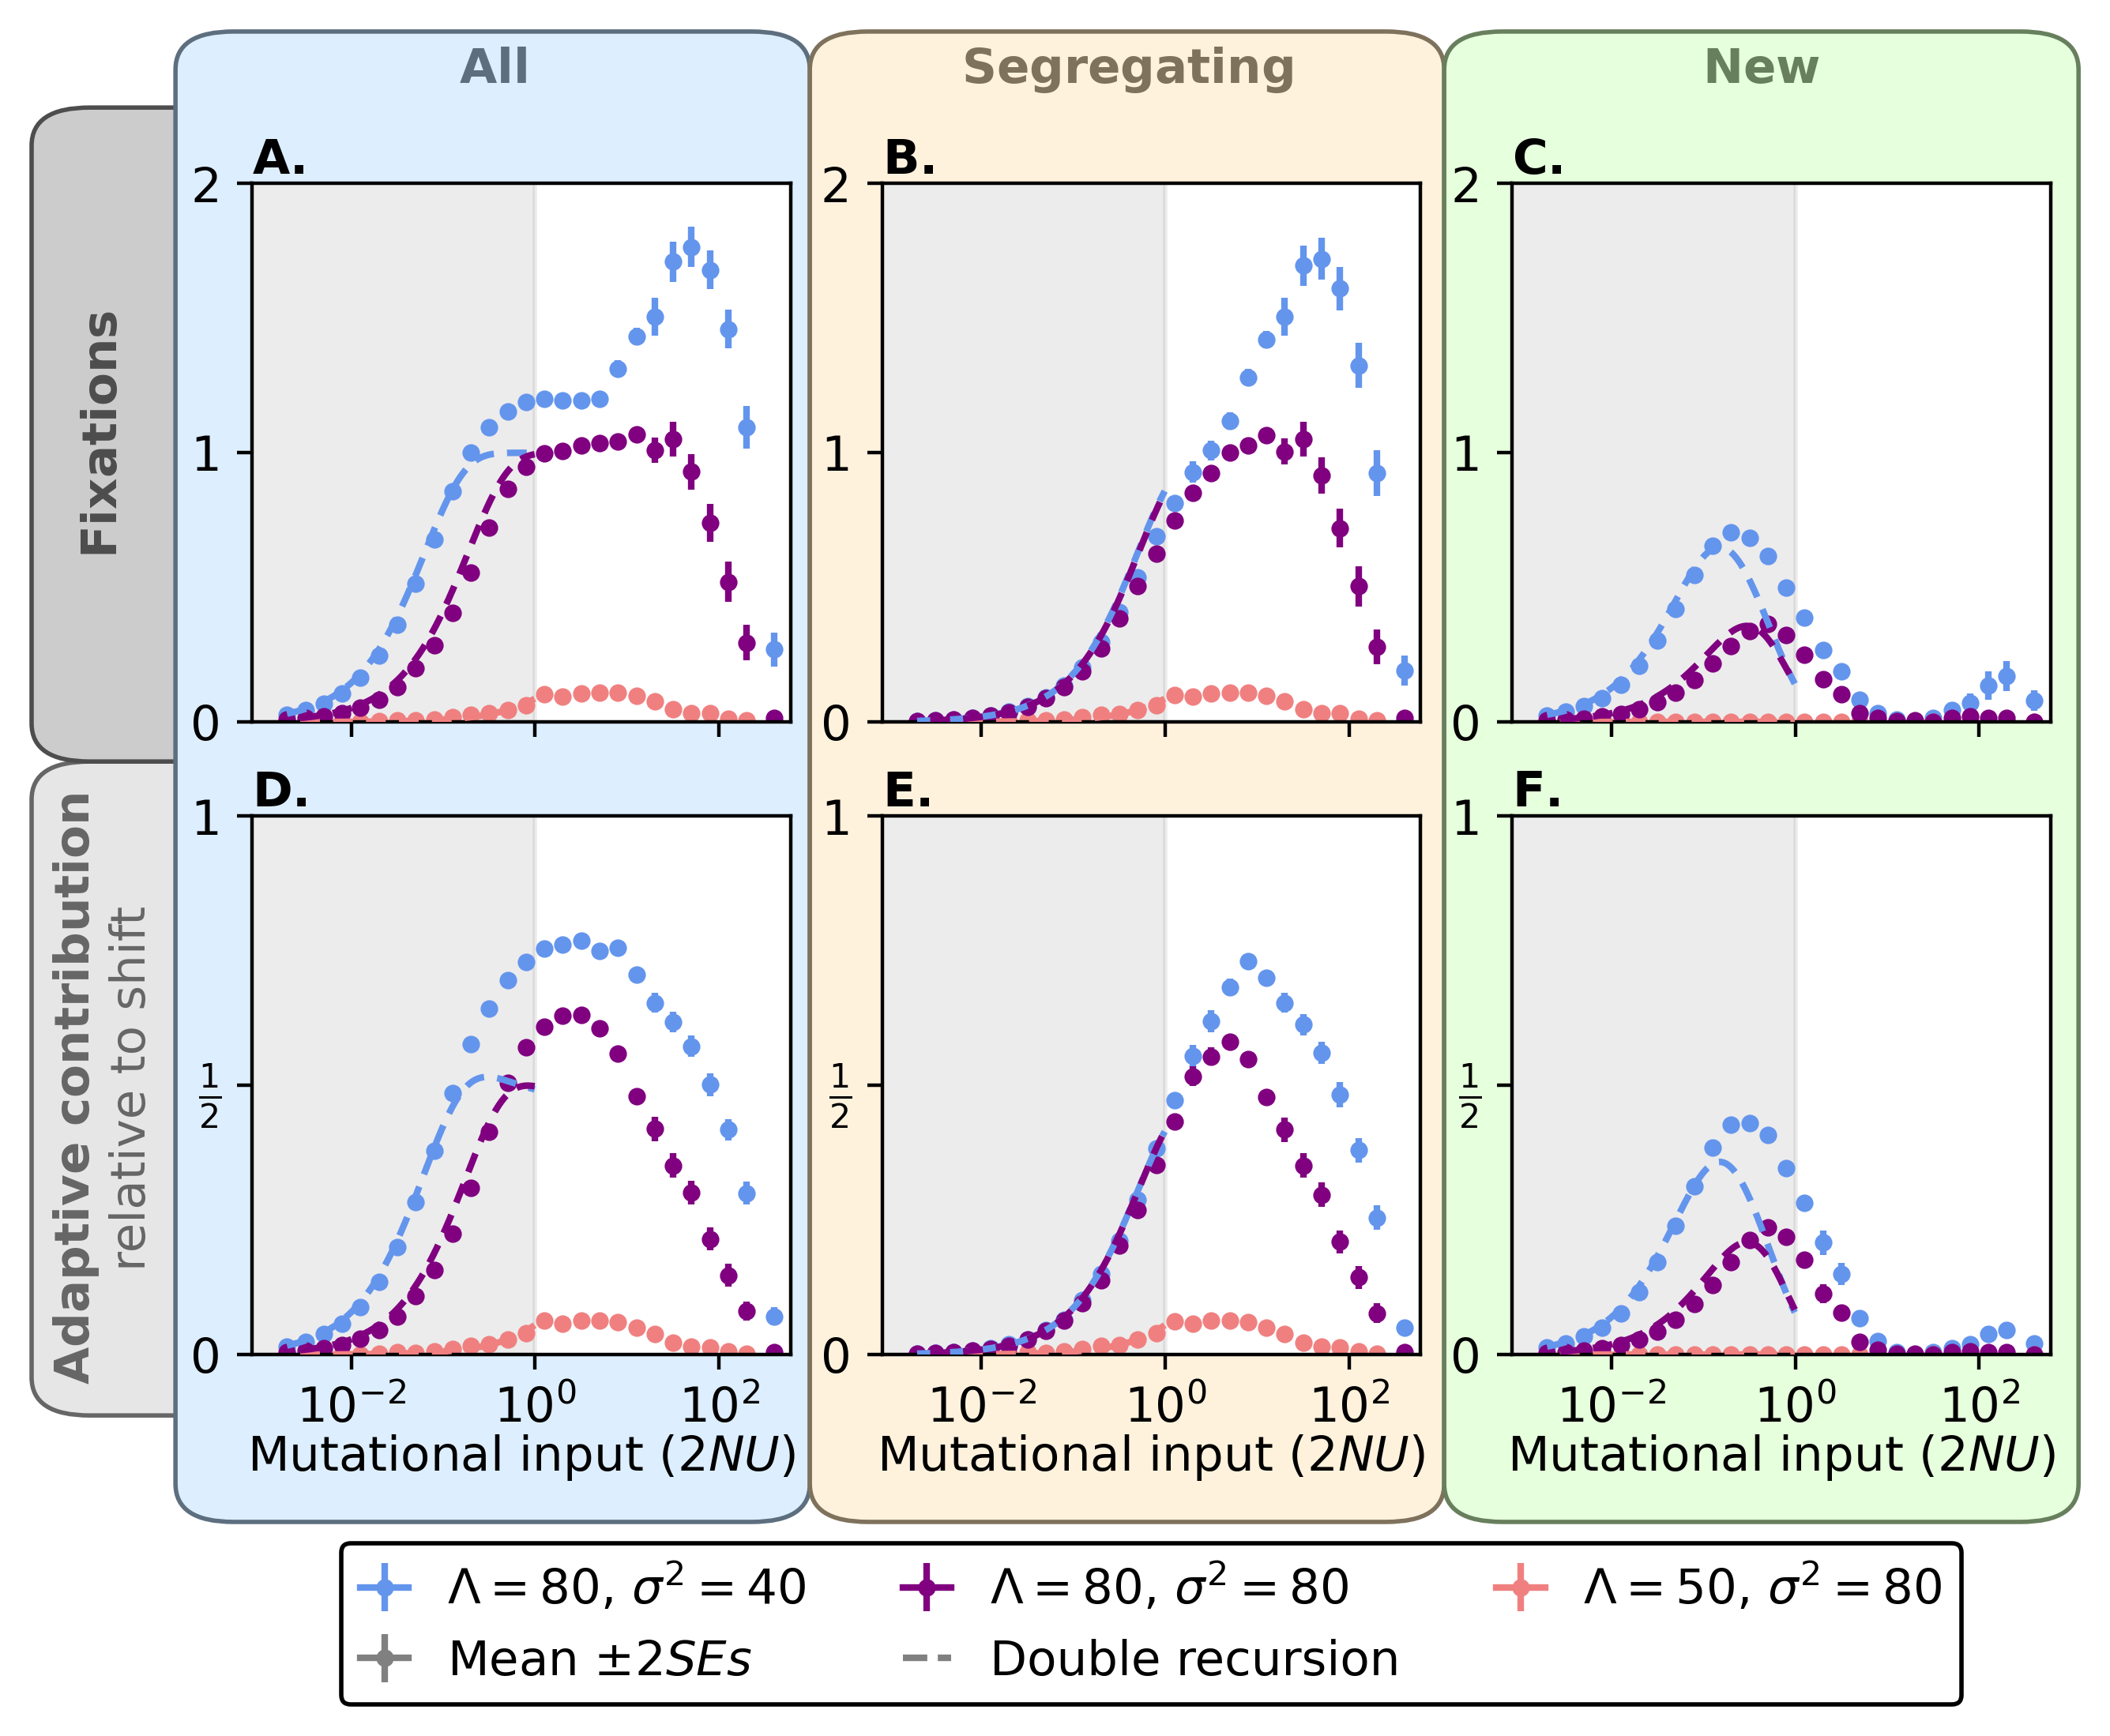

In [6]:

def make_figure_square(fig_width,fig_height =6.5):
    square = False
    while not square:

        fig,ax = main(fig_height=fig_height,fig_width = fig_width)
        bbox = ax.get_window_extent()
        # Convert the bounding box to inches using the figure's DPI
        width_inches = bbox.width / fig.dpi
        height_inches = bbox.height / fig.dpi
        height_inches_new = fig_height*width_inches/height_inches
        if not np.isclose(width_inches,height_inches,rtol=0.05):
            if height_inches_new < 1:
                height_inches_new = np.random.random()*(fig_height-1)+1
            square = False
            fig_height = height_inches_new
        else:
            square = True
            height_inches_new = fig_height
    print('fh',fig_height)
    return fig

def make_figure_width(fig_width,fig_height=6.5,depthd=0):
    if depthd > 20:
        raise ValueError
    fig = make_figure_square(fig_height=fig_height,fig_width=fig_width)
        
    # Get the renderer for the figure canvas
    renderer = fig.canvas.get_renderer()

    # Get the tight bounding box in pixels
    tight_width_inches = fig.get_tightbbox(renderer).width

    if np.isclose(tight_width_inches,6.5,rtol=0.01):
        print('fw',fig_width)
        plt.savefig('./Figure_S6_idk.png',dpi=300,bbox_inches='tight')
    else:
        make_figure_width(fig_width=fig_width*6.5/tight_width_inches,depthd=depthd+1)

# make_figure_width(fig_width=7.55813953488372)
make_figure_width(fig_width=7.344632768361582,fig_height = 4.813864456866591)
